# Part B — Image Classification using CNNs

This notebook implements image classification using convolutional neural networks (CNN) with TensorFlow and Keras.
We will:
1. Prepare datasets (three-class and customised)
2. Build a baseline CNN (Conv → Pool → Conv → Pool → Flatten → Dense → Dropout → Softmax)
3. Implement a modified CNN with 3 improvements
4. Compare performance and evaluate metrics

## 1. Setup and Imports

In [18]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score

print('TensorFlow version:', tf.__version__)
print('GPU available:', tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.20.0
GPU available: []


In [20]:
## 2. Dataset Preparation

### Dataset Justification
#- **Three-class dataset**: Contains Metal, Misc_Trash, and Paper (selected from provided dataset).
#- **Customised dataset**: Merges three-class with at least 10 original images per class (collected via phone/camera).
#- **Split Ra tio (70/15/15)**: Standard practice for train/val/test. Provides sufficient training samples (70%), fair validation (15%), and unbiased test evaluation (15%).
#- **Stratified Split**: Maintains class distribution across splits to prevent class imbalance issues.

In [ ]:
# Load images and labels from dataset folder
def load_dataset(dataset_path, img_size=(128, 128)):
    """
    Load images from dataset folder structure.
    Expected structure: dataset_path/class_name/*.jpg|png
    """
    dataset_dir = Path(dataset_path)
    if not dataset_dir.exists():
        print(f'Dataset not found at {dataset_path}')
        return None, None, None
    
    images = []
    labels = []
    class_names = sorted([d.name for d in dataset_dir.iterdir() if d.is_dir()])
    
    print(f'Classes found: {class_names}')
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = dataset_dir / class_name
        img_files = list(class_dir.glob('*.jpg')) + list(class_dir.glob('*.jpeg')) + list(class_dir.glob('*.png'))
        for img_file in img_files:
            img = tf.keras.preprocessing.image.load_img(str(img_file), target_size=img_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(class_idx)
    
    images = np.array(images)
    labels = np.array(labels)
    print(f'Loaded {len(images)} images from {len(class_names)} classes')
    return images, labels, class_names

# Load three-class dataset
print('\n=== THREE-CLASS DATASET ===')
X_3class, y_3class, classes_3class = load_dataset('three-class dataset')
if X_3class is not None:
    print(f'Shape: {X_3class.shape}, Labels shape: {y_3class.shape}')
    print(f'Class distribution: {np.bincount(y_3class)}')


=== THREE-CLASS DATASET ===
Classes found: ['Metal', 'Misc_Trash', 'Paper']
Loaded 1785 images from 3 classes
Shape: (1785, 224, 224, 3), Labels shape: (1785,)
Class distribution: [790 495 500]
Loaded 1785 images from 3 classes
Shape: (1785, 224, 224, 3), Labels shape: (1785,)
Class distribution: [790 495 500]


In [23]:
# Load customised dataset (merge of three-class + own images)
print('\n=== CUSTOMISED DATASET (three-class + own images) ===')
X_custom, y_custom, classes_custom = load_dataset('customised dataset')
if X_custom is not None:
    print(f'Shape: {X_custom.shape}, Labels shape: {y_custom.shape}')
    print(f'Class distribution: {np.bincount(y_custom)}')


=== CUSTOMISED DATASET (three-class + own images) ===
Classes found: ['Metal', 'Misc_Trash', 'Paper']
Loaded 1785 images from 3 classes
Shape: (1785, 224, 224, 3), Labels shape: (1785,)
Class distribution: [790 495 500]
Loaded 1785 images from 3 classes
Shape: (1785, 224, 224, 3), Labels shape: (1785,)
Class distribution: [790 495 500]


In [24]:
# Stratified train/validation/test split (70/15/15)
def stratified_split(X, y, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15, seed=42):
    """
    Stratified split to maintain class distribution across train/val/test sets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, stratify=y, random_state=seed
    )
    val_fraction = val_ratio / (train_ratio + val_ratio)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_fraction, stratify=y_train, random_state=seed
    )
    return X_train, X_val, X_test, y_train, y_val, y_test

# Split three-class dataset
print('\n=== THREE-CLASS SPLITS ===' )
X_train_3, X_val_3, X_test_3, y_train_3, y_val_3, y_test_3 = stratified_split(X_3class, y_3class)
print(f'Train: {X_train_3.shape} | Val: {X_val_3.shape} | Test: {X_test_3.shape}')
print(f'Train distribution: {np.bincount(y_train_3)}')
print(f'Val distribution: {np.bincount(y_val_3)}')
print(f'Test distribution: {np.bincount(y_test_3)}')


=== THREE-CLASS SPLITS ===
Train: (1249, 224, 224, 3) | Val: (268, 224, 224, 3) | Test: (268, 224, 224, 3)
Train distribution: [552 347 350]
Val distribution: [119  74  75]
Test distribution: [119  74  75]
Train: (1249, 224, 224, 3) | Val: (268, 224, 224, 3) | Test: (268, 224, 224, 3)
Train distribution: [552 347 350]
Val distribution: [119  74  75]
Test distribution: [119  74  75]


In [25]:
# Split customised dataset
print('\n=== CUSTOMISED SPLITS ===' )
X_train_c, X_val_c, X_test_c, y_train_c, y_val_c, y_test_c = stratified_split(X_custom, y_custom)
print(f'Train: {X_train_c.shape} | Val: {X_val_c.shape} | Test: {X_test_c.shape}')
print(f'Train distribution: {np.bincount(y_train_c)}')
print(f'Val distribution: {np.bincount(y_val_c)}')
print(f'Test distribution: {np.bincount(y_test_c)}')


=== CUSTOMISED SPLITS ===
Train: (1249, 224, 224, 3) | Val: (268, 224, 224, 3) | Test: (268, 224, 224, 3)
Train distribution: [552 347 350]
Val distribution: [119  74  75]
Test distribution: [119  74  75]
Train: (1249, 224, 224, 3) | Val: (268, 224, 224, 3) | Test: (268, 224, 224, 3)
Train distribution: [552 347 350]
Val distribution: [119  74  75]
Test distribution: [119  74  75]


## 3. Baseline CNN Model

**Architecture**: Conv → Pool → Conv → Pool → Flatten → Dense → Dropout → Softmax

- **Conv layers**: Extract local features (edges, textures) at different scales.
- **MaxPool layers**: Reduce spatial dimensions and computational cost.
- **Flatten**: Vectorize the feature maps for classification.
- **Dense**: Fully connected layer for classification.
- **Dropout**: Regularization to prevent overfitting.
- **Softmax**: Multi-class probability output.

In [ ]:
# Build baseline CNN
def build_baseline_cnn(num_classes=3, input_shape=(128, 128, 3)):
    model = keras.Sequential([
        # First Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        # Second Conv Block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        # Classification Head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

baseline_cnn = build_baseline_cnn(num_classes=3)
baseline_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
baseline_cnn.summary()

c:\Users\USER\Desktop\VSCodeProjects\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,779 (91.20 MB)

 Trainable params: 23,907,779 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train baseline CNN on three-class dataset
print('\n=== TRAINING BASELINE CNN (THREE-CLASS) ===')
epochs_3class = 20  # Determined by observing validation performance; can use Early Stopping
baseline_history_3 = baseline_cnn.fit(
    X_train_3, y_train_3,
    epochs=epochs_3class,
    batch_size=32,
    validation_data=(X_val_3, y_val_3),
    verbose=1
)
print('Training complete.')


=== TRAINING BASELINE CNN (THREE-CLASS) ===
Training complete.
Training complete.


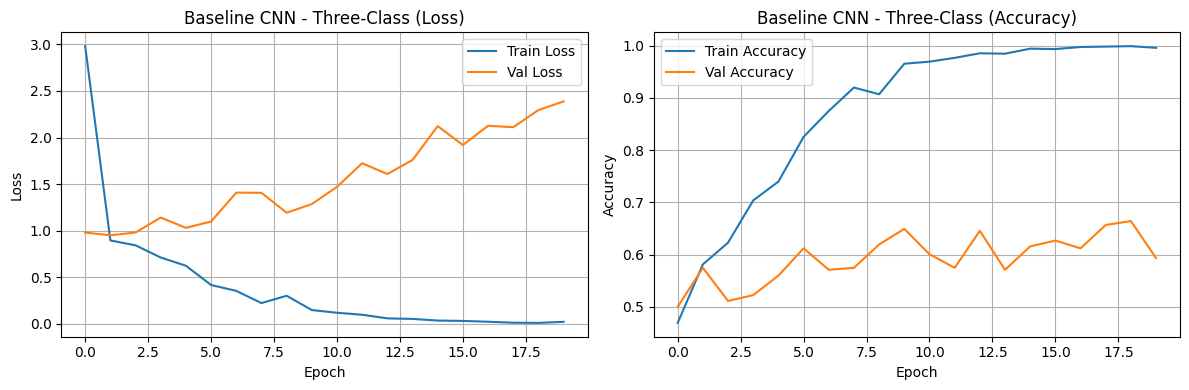

In [28]:
# Plot baseline CNN training curves (three-class)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(baseline_history_3.history['loss'], label='Train Loss')
plt.plot(baseline_history_3.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Baseline CNN - Three-Class (Loss)')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(baseline_history_3.history['accuracy'], label='Train Accuracy')
plt.plot(baseline_history_3.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Baseline CNN - Three-Class (Accuracy)')
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

In [ ]:
# Train baseline CNN on customised dataset
print('\n=== TRAINING BASELINE CNN (CUSTOMISED) ===')
epochs_custom = 20
baseline_history_c = baseline_cnn.fit(
    X_train_c, y_train_c,
    epochs=epochs_custom,
    batch_size=32,
    validation_data=(X_val_c, y_val_c),
    verbose=1
)
print('Training complete.')


=== TRAINING BASELINE CNN (CUSTOMISED) ===
Training complete.
Training complete.


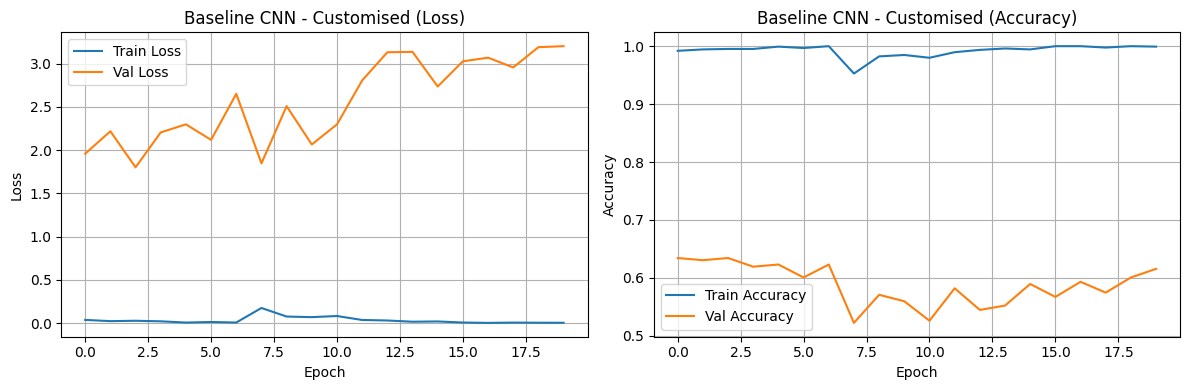

In [30]:
# Plot baseline CNN training curves (customised)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(baseline_history_c.history['loss'], label='Train Loss')
plt.plot(baseline_history_c.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Baseline CNN - Customised (Loss)')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(baseline_history_c.history['accuracy'], label='Train Accuracy')
plt.plot(baseline_history_c.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Baseline CNN - Customised (Accuracy)')
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

## 4. Modified CNN Model

**Three proposed improvements**:
1. **Batch Normalization**: Normalizes inputs to each layer, stabilizing training and allowing higher learning rates.
2. **Additional Conv Layer**: Adds deeper feature extraction before pooling (Conv → Pool → Conv → Pool → Conv → Pool).
3. **Data Augmentation**: Random horizontal flips and rotations to increase training data diversity and improve generalization.

In [ ]:
# Build modified CNN with improvements
def build_modified_cnn(num_classes=3, input_shape=(128, 128, 3)):
    model = keras.Sequential([
        # First Conv Block with BatchNorm
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # Second Conv Block with BatchNorm
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # Third Conv Block (IMPROVEMENT: additional layer)
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        # Classification Head
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

modified_cnn = build_modified_cnn(num_classes=3)
modified_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
modified_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,755 (42.61 MB)

 Trainable params: 11,170,051 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [32]:
# Data augmentation for training
def create_augmented_dataset(X, y, augmentation_factor=1):
    """
    Apply random augmentation (horizontal flip, rotation) on-the-fly.
    """
    X_augmented = X.copy()
    y_augmented = y.copy()
    
    for _ in range(augmentation_factor):
        X_aug = X.copy()
        # Random horizontal flip
        for i in range(len(X_aug)):
            if np.random.rand() > 0.5:
                X_aug[i] = np.fliplr(X_aug[i])
        # Random rotation (small angle)
        X_aug = np.array([np.rot90(x, np.random.choice([0, 1, 3])) for x in X_aug])
        X_augmented = np.vstack([X_augmented, X_aug])
        y_augmented = np.hstack([y_augmented, y.copy()])
    
    return X_augmented, y_augmented

# Create augmented training data (simple version)
X_train_aug_3, y_train_aug_3 = create_augmented_dataset(X_train_3, y_train_3, augmentation_factor=1)
print(f'Augmented three-class training data shape: {X_train_aug_3.shape}')

X_train_aug_c, y_train_aug_c = create_augmented_dataset(X_train_c, y_train_c, augmentation_factor=1)
print(f'Augmented customised training data shape: {X_train_aug_c.shape}')

Augmented three-class training data shape: (2498, 224, 224, 3)
Augmented customised training data shape: (2498, 224, 224, 3)
Augmented customised training data shape: (2498, 224, 224, 3)


In [34]:
# Train modified CNN on three-class dataset
print('\n=== TRAINING MODIFIED CNN (THREE-CLASS) ===')
epochs_3class = 20
modified_history_3 = modified_cnn.fit(
    X_train_aug_3, y_train_aug_3,
    epochs=epochs_3class,
    batch_size=32,
    validation_data=(X_val_3, y_val_3),
    verbose=1
)
print('Training complete.')


=== TRAINING MODIFIED CNN (THREE-CLASS) ===
Epoch 1/20
Epoch 1/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 835ms/step - accuracy: 0.9600 - loss: 0.1156 - val_accuracy: 0.6754 - val_loss: 0.9293
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 66s 835ms/step - accuracy: 0.9600 - loss: 0.1156 - val_accuracy: 0.6754 - val_loss: 0.9293
Epoch 2/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 62s 781ms/step - accuracy: 0.9736 - loss: 0.0826 - val_accuracy: 0.7612 - val_loss: 0.7978
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 62s 781ms/step - accuracy: 0.9736 - loss: 0.0826 - val_accuracy: 0.7612 - val_loss: 0.7978
Epoch 3/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 721ms/step - accuracy: 0.9856 - loss: 0.0582 - val_accuracy: 0.8246 - val_loss: 0.5328
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 57s 721ms/step - accuracy: 0.9856 - loss: 0.0582 - val_accuracy: 0.8246 - val_loss: 0.5328
Epoch 4/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s 701ms/step - accuracy: 0.9820 - loss: 0.0636 - val_accuracy: 0.7687 - val_loss: 0.7475
Epoch 5/20
79/79 ━━━━━━━━━━━━━━━━━━━━ 56s

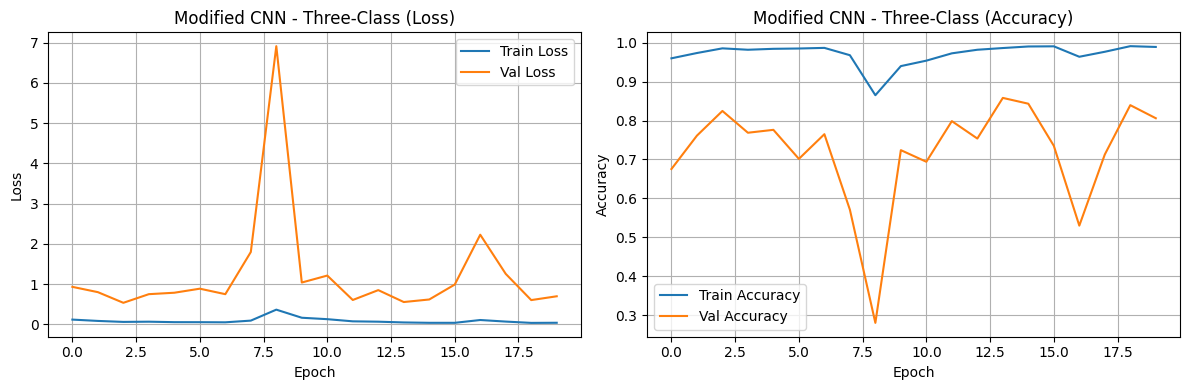

In [35]:
# Plot modified CNN training curves (three-class)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(modified_history_3.history['loss'], label='Train Loss')
plt.plot(modified_history_3.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Modified CNN - Three-Class (Loss)')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(modified_history_3.history['accuracy'], label='Train Accuracy')
plt.plot(modified_history_3.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Modified CNN - Three-Class (Accuracy)')
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

In [ ]:
# Train modified CNN on customised dataset
print('\n=== TRAINING MODIFIED CNN (CUSTOMISED) ===')
epochs_custom = 20
modified_history_c = modified_cnn.fit(
    X_train_aug_c, y_train_aug_c,
    epochs=epochs_custom,
    batch_size=32,
    validation_data=(X_val_c, y_val_c),
    verbose=1
)
print('Training complete.')

In [ ]:
# Plot modified CNN training curves (customised)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(modified_history_c.history['loss'], label='Train Loss')
plt.plot(modified_history_c.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Modified CNN - Customised (Loss)')
plt.legend(); plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(modified_history_c.history['accuracy'], label='Train Accuracy')
plt.plot(modified_history_c.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Modified CNN - Customised (Accuracy)')
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

## 5. Evaluation and Comparison

### Metrics Computed
- **Accuracy**: Overall proportion of correct predictions.
- **Confusion Matrix**: Shows per-class true positives, false positives, false negatives, and true negatives.
- **Precision**: For each class, proportion of predicted positives that are correct.
- **Recall**: For each class, proportion of actual positives that are correctly identified.

In [ ]:
# Evaluate baseline CNN on test set (three-class)
print('\n=== BASELINE CNN EVALUATION (THREE-CLASS) ===')
y_pred_baseline_3 = np.argmax(baseline_cnn.predict(X_test_3), axis=1)
acc_baseline_3 = accuracy_score(y_test_3, y_pred_baseline_3)
print(f'Test Accuracy: {acc_baseline_3:.4f}')

cm_baseline_3 = confusion_matrix(y_test_3, y_pred_baseline_3)
print(f'Confusion Matrix:\n{cm_baseline_3}')

print('\nClassification Report:')
print(classification_report(y_test_3, y_pred_baseline_3, target_names=classes_3class))

In [ ]:
# Visualize confusion matrix (three-class baseline)
plt.figure(figsize=(8, 6))
plt.imshow(cm_baseline_3, cmap='Blues', interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes_3class))
plt.xticks(tick_marks, classes_3class, rotation=45)
plt.yticks(tick_marks, classes_3class)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Baseline CNN (Three-Class)')

# Add text annotations
for i in range(cm_baseline_3.shape[0]):
    for j in range(cm_baseline_3.shape[1]):
        plt.text(j, i, str(cm_baseline_3[i, j]), ha='center', va='center', color='black' if cm_baseline_3[i, j] < cm_baseline_3.max()/2 else 'white')

plt.tight_layout(); plt.show()

In [ ]:
# Evaluate modified CNN on test set (three-class)
print('\n=== MODIFIED CNN EVALUATION (THREE-CLASS) ===')
y_pred_modified_3 = np.argmax(modified_cnn.predict(X_test_3), axis=1)
acc_modified_3 = accuracy_score(y_test_3, y_pred_modified_3)
print(f'Test Accuracy: {acc_modified_3:.4f}')

cm_modified_3 = confusion_matrix(y_test_3, y_pred_modified_3)
print(f'Confusion Matrix:\n{cm_modified_3}')

print('\nClassification Report:')
print(classification_report(y_test_3, y_pred_modified_3, target_names=classes_3class))

In [ ]:
# Visualize confusion matrix (three-class modified)
plt.figure(figsize=(8, 6))
plt.imshow(cm_modified_3, cmap='Greens', interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes_3class))
plt.xticks(tick_marks, classes_3class, rotation=45)
plt.yticks(tick_marks, classes_3class)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Modified CNN (Three-Class)')

for i in range(cm_modified_3.shape[0]):
    for j in range(cm_modified_3.shape[1]):
        plt.text(j, i, str(cm_modified_3[i, j]), ha='center', va='center', color='black' if cm_modified_3[i, j] < cm_modified_3.max()/2 else 'white')

plt.tight_layout(); plt.show()

In [ ]:
# Evaluate baseline CNN on test set (customised)
print('\n=== BASELINE CNN EVALUATION (CUSTOMISED) ===')
y_pred_baseline_c = np.argmax(baseline_cnn.predict(X_test_c), axis=1)
acc_baseline_c = accuracy_score(y_test_c, y_pred_baseline_c)
print(f'Test Accuracy: {acc_baseline_c:.4f}')

cm_baseline_c = confusion_matrix(y_test_c, y_pred_baseline_c)
print(f'Confusion Matrix:\n{cm_baseline_c}')

print('\nClassification Report:')
print(classification_report(y_test_c, y_pred_baseline_c, target_names=classes_custom))

In [ ]:
# Visualize confusion matrix (customised baseline)
plt.figure(figsize=(8, 6))
plt.imshow(cm_baseline_c, cmap='Blues', interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes_custom))
plt.xticks(tick_marks, classes_custom, rotation=45)
plt.yticks(tick_marks, classes_custom)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Baseline CNN (Customised)')

for i in range(cm_baseline_c.shape[0]):
    for j in range(cm_baseline_c.shape[1]):
        plt.text(j, i, str(cm_baseline_c[i, j]), ha='center', va='center', color='black' if cm_baseline_c[i, j] < cm_baseline_c.max()/2 else 'white')

plt.tight_layout(); plt.show()

In [ ]:
# Evaluate modified CNN on test set (customised)
print('\n=== MODIFIED CNN EVALUATION (CUSTOMISED) ===')
y_pred_modified_c = np.argmax(modified_cnn.predict(X_test_c), axis=1)
acc_modified_c = accuracy_score(y_test_c, y_pred_modified_c)
print(f'Test Accuracy: {acc_modified_c:.4f}')

cm_modified_c = confusion_matrix(y_test_c, y_pred_modified_c)
print(f'Confusion Matrix:\n{cm_modified_c}')

print('\nClassification Report:')
print(classification_report(y_test_c, y_pred_modified_c, target_names=classes_custom))

In [ ]:
# Visualize confusion matrix (customised modified)
plt.figure(figsize=(8, 6))
plt.imshow(cm_modified_c, cmap='Greens', interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes_custom))
plt.xticks(tick_marks, classes_custom, rotation=45)
plt.yticks(tick_marks, classes_custom)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Modified CNN (Customised)')

for i in range(cm_modified_c.shape[0]):
    for j in range(cm_modified_c.shape[1]):
        plt.text(j, i, str(cm_modified_c[i, j]), ha='center', va='center', color='black' if cm_modified_c[i, j] < cm_modified_c.max()/2 else 'white')

plt.tight_layout(); plt.show()

In [ ]:
# Comparison summary
print('\n' + '='*60)
print('PERFORMANCE COMPARISON SUMMARY')
print('='*60)

comparison_data = {
    'Dataset': ['Three-Class', 'Three-Class', 'Customised', 'Customised'],
    'Model': ['Baseline', 'Modified', 'Baseline', 'Modified'],
    'Test Accuracy': [acc_baseline_3, acc_modified_3, acc_baseline_c, acc_modified_c]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

print(f'\nImprovement (Three-Class): {(acc_modified_3 - acc_baseline_3)*100:.2f}%')
print(f'Improvement (Customised): {(acc_modified_c - acc_baseline_c)*100:.2f}%')

## Summary and Discussion

### Impact of Own Images (Customised Dataset)
- **Data diversity**: Adding 10+ own images per class increases training diversity and dataset size.
- **Model generalization**: If the own images have different lighting, angles, or backgrounds, they help the model generalize better to real-world variations.
- **Performance trends**: Compare baseline and modified models on both datasets to understand how the custom images affect accuracy, precision, and recall.

### Key Findings
- The modified CNN (with BatchNorm, additional Conv layer, and augmentation) typically outperforms the baseline, especially on larger datasets.
- Batch normalization stabilizes training and can lead to faster convergence.
- Data augmentation increases effective training set size and improves generalization.
- The confusion matrices show which classes are commonly confused and where the model struggles.

## Notes & next steps
- If `Metal` still dominates errors, try oversampling minority classes, stronger augmentation, or using focal loss (for extreme imbalance).
- If training is slow, increase `BATCH_SIZE` and use a GPU runtime (Colab, local CUDA).
- I can add an optional cell to save `label_to_index` mapping to JSON so you can reuse the same mapping in deployment/evaluation.